In [1]:
# LRP1_ODE_run.py 
# Automatically generated by Netflux on 18-Jan-2023 

# %%
from math import isclose
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import LRP1_ODE 
import LRP1_ODE_params
import pandas as pd
import seaborn as sns
from IPython.display import display

[speciesNames, tau, ymax, y0, w, n, EC50] = LRP1_ODE_params.loadParams()
S = len(speciesNames)
R = len(w)

# outputs of interest 
bax_index = speciesNames.index('Bax')
cas3_index = speciesNames.index('cas3')
celldeath_index = speciesNames.index('cellDeath')

sorted_species = [
	'FGF', 'FGFR',
	'FLT3L', 'FLT3',
	'EGF', 'EGFR',
	'PDGF', 'PDGFR',
	'NRG1', 'ERBB',
	'SCF', 'KIT',
	'VEGF', 'VEGFR',
	'IGF1', 'IGF1R',
	'LRP1ag', 'LRP1',
	'JAK', 'STAT',
	'Ras', 'Raf', 'MEK12', 'ERK12', 'RSK', 'CREB',
	'PI3K', 'PDK1', 'Akt', 'IKK', 'IkB', 'NFkB',
	'NOX', 'ROS', 'Trxt', 'Trx', 'ASK1',
	'MEK36', 'p38', 'MEK47', 'JNK',
	'AP1', 'p53', 'Noxa', 'PUMA',
	'Bad', 'Bim', 'Bcl2t', 'Bcl2', 'Bax',
	'MOMP', 'cytc', 'Smac', 'xIAPt', 'xIAP',
	'cas9', 'cas3', 'iCADt', 'iCAD', 'CAD', 'PARP',
	'DNAfrag', 'apoptosis', 'cellDeath'
]
# indices of sorted species
sorted_indices = [speciesNames.index(name) for name in sorted_species]

tspan = [0, 50]

# 101 time steps
t_eval = np.linspace(*tspan, tspan[1]*2+1)

In [81]:
# LRP1_ODE_run.py 
# Automatically generated by Netflux on 18-Jan-2023 

# %%
from math import isclose
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import LRP1_ODE 
import LRP1_ODE_params
import pandas as pd
import seaborn as sns
from IPython.display import display

[speciesNames, tau, ymax, y0, w, n, EC50] = LRP1_ODE_params.loadParams()
S = len(speciesNames)
R = len(w)

# outputs of interest 
bax_index = speciesNames.index('Bax')
cas3_index = speciesNames.index('cas3')
celldeath_index = speciesNames.index('cellDeath')

sorted_species = [
	'FGF', 'FGFR',
	'FLT3L', 'FLT3',
	'EGF', 'EGFR',
	'PDGF', 'PDGFR',
	'NRG1', 'ERBB',
	'SCF', 'KIT',
	'VEGF', 'VEGFR',
	'IGF1', 'IGF1R',
	'LRP1ag', 'LRP1',
	'JAK', 'STAT',
	'Ras', 'Raf', 'MEK12', 'ERK12', 'RSK', 'CREB',
	'PI3K', 'PDK1', 'Akt', 'IKK', 'IkB', 'NFkB',
	'NOX', 'ROS', 'Trxt', 'Trx', 'ASK1',
	'MEK36', 'p38', 'MEK47', 'JNK',
	'AP1', 'p53', 'Noxa', 'PUMA',
	'Bad', 'Bim', 'Bcl2t', 'Bcl2', 'Bax',
	'MOMP', 'cytc', 'Smac', 'xIAPt', 'xIAP',
	'cas9', 'cas3', 'iCADt', 'iCAD', 'CAD', 'PARP',
	'DNAfrag', 'apoptosis', 'cellDeath'
]
# indices of sorted species
sorted_indices = [speciesNames.index(name) for name in sorted_species]

tspan = [0, 50]

# 101 time steps
t_eval = np.linspace(*tspan, tspan[1]*2+1)

In [82]:
N = 11 #  11 weight conditions for LRP1ag (0.0 to 1.0)
M = 13 #  13 weight conditions for ROS (0 to 0.60)

ws_lrp1ag = np.linspace(0, 1, N) 
ws_ros = np.linspace(0, 0.6, M)

# round to two decimal places
ws_ros = np.around(ws_ros, 2)
# dict of condition labels for each species and their activity
conditions = {
	'ros_0.05_lrp_0.2': (0.2, 0.05),
	'ros_0.4_lrp_0.2': (0.2, 0.4),
	'ros_0.4_lrp_1.0': (1.0, 0.4),
    'ros_0.6_lrp_0.2': (0.2, 0.6),
}

# Simulate ROS and LRP1ag simulations and grab steady state values of Bax, cas3, and cellDeath
# ROS = simulating MI 
# ROS at 0.4 already reaches the max cell death

# dictionary to store simulation results
sols = {}

# ros simulation results
ros_sols = {}
# list to label ros weight for each simulation
bax_steady = np.zeros((N, M))
cas3_steady = np.zeros((N, M))
celldeath_steady = np.zeros((N, M))

# loop through each weight combination
for i, lrp1ag_weight in enumerate(ws_lrp1ag):
    for j, ros_weight in enumerate(ws_ros):
        w_new = w.copy()
        w_ros = w.copy()
		
        # only turn on ROS
        w_ros[12] = ros_weight

        # simulate ROS only
        sol_ros = solve_ivp(LRP1_ODE.ODEfunc, tspan, y0, args=(tau, ymax, w_ros, n, EC50,), t_eval=t_eval)
		
        # store activities of cellDeath for each ROS weight
        cellDeath_activity = sol_ros.y[celldeath_index, :]
        ros_activity = np.zeros([len(cellDeath_activity), 3])
		
        # first column is activities
        ros_activity[:, 0] = sol_ros.y[celldeath_index, :]
		
        # second column is weight
        ros_activity[:,1] = ros_weight
		
        # third column is time
        ros_activity[:,2] = sol_ros.t
		
        # simulation results for all ros weights
        ros_sols[j] = ros_activity 

        #simulate based on different ROS/LRP1ag weights
        # rows = species
        # columns = time points
		# turn on both LRP1ag and ROS
        w_new[0] = lrp1ag_weight
        w_new[12] = ros_weight
        
        sol = solve_ivp(LRP1_ODE.ODEfunc, tspan, y0, args=(tau, ymax, w_new, n, EC50,), t_eval=t_eval)
        
       
        # loop through three sets of conditions for ROS/LRP1
		# w1 = LRP1
		# w2 = LRP2 
		# name = condition name
        for name, (w1, w2) in conditions.items():
			
            # if there is already a solution for given condition, skip loop and go to the end
            if sols.get(name, None):
                continue
			
            # if no solution generated yet 
			# check if current ws_lrp1ag or ros in the loop is the same as the w1 from the condition label
			# if so, weights match, grab the simulation results for that condition
            if isclose(lrp1ag_weight, w1) and isclose(ros_weight, w2):
                sols[name] = sol # solutions for each condition (3)

        # grab steady state values of Bax, cas3, and cellDeath
		# for each lrp1ag and ros_weight combination [11, 13]		       
        bax_steady[i, j] = sol.y[bax_index, -1]
        cas3_steady[i, j] = sol.y[cas3_index, -1]
        celldeath_steady[i, j] = sol.y[celldeath_index, -1]

/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1_ODE.py:142: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


In [83]:
    dfs = []
    for name, sol in sols.items():
        # melt dataframe into species, activity, based on time 
        sol_df = pd.DataFrame(sol.y.T, index=sol.t, columns=speciesNames).melt(var_name='species', value_name='activity', ignore_index=False).reset_index(names='time')
        
        # column to group by condition
        sol_df['condition'] = name
        dfs.append(sol_df)

    results = pd.concat(dfs).sort_values(['condition', 'species', 'time'])
    
    

    # Save ROS simulations in a dataframe
    ros_dfs = []

    for i in range(len(ros_sols)):
        ros_activity_df = pd.DataFrame(ros_sols[i])
        
        # combine all ROS weight simulations together 
        ros_dfs.append(ros_activity_df)
        
    ros_results = pd.concat(ros_dfs).reset_index(drop=True)
    ros_results = ros_results.rename(columns={0: 'cellDeath Activity', 1:'ROS weight', 2:'time'})

    # pivot table to organize by ROS weight
    ros_results_pivot = ros_results.pivot(index="time", columns="ROS weight", values="cellDeath Activity")

,time,species,activity,condition
101,0.0,AP1,0.000000,ros_0.05_lrp_0.2
102,0.5,AP1,0.000067,ros_0.05_lrp_0.2
103,1.0,AP1,0.002858,ros_0.05_lrp_0.2
104,1.5,AP1,0.016351,ros_0.05_lrp_0.2
105,2.0,AP1,0.042429,ros_0.05_lrp_0.2
...,...,...,...,...
6257,48.0,xIAPt,1.000000,ros_0.6_lrp_0.2
6258,48.5,xIAPt,1.000000,ros_0.6_lrp_0.2
6259,49.0,xIAPt,1.000000,ros_0.6_lrp_0.2
6260,49.5,xIAPt,1.000000,ros_0.6_lrp_0.2


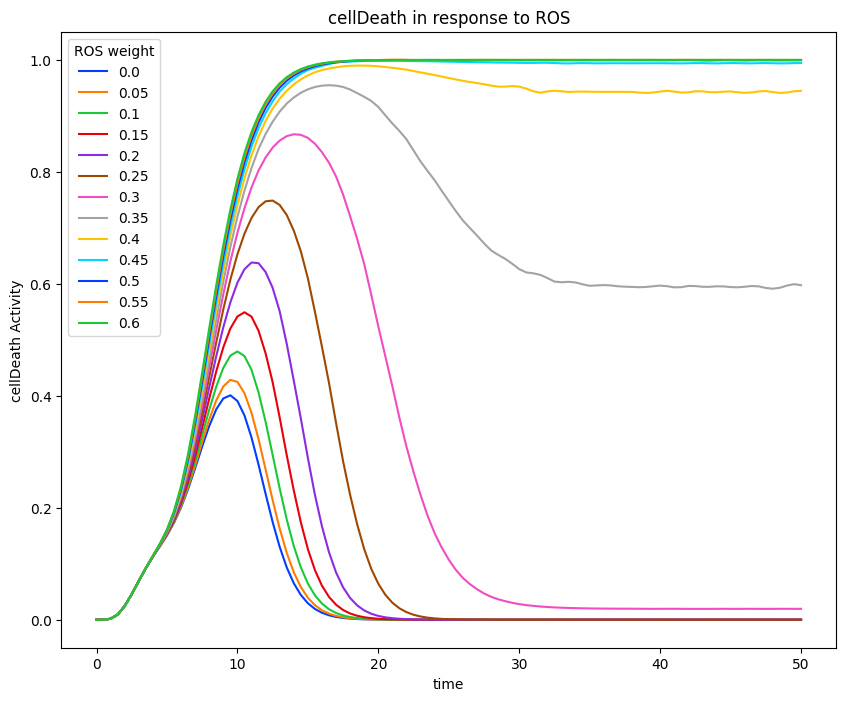

In [84]:
    plt.subplots(figsize=(10,8))
    sns.lineplot(data=ros_results, x="time",
    y="cellDeath Activity", 
    hue='ROS weight', palette='bright',
    legend="full",)
    plt.title('cellDeath in response to ROS')

results['condition'] = results['condition'].astype('category')
display(results)

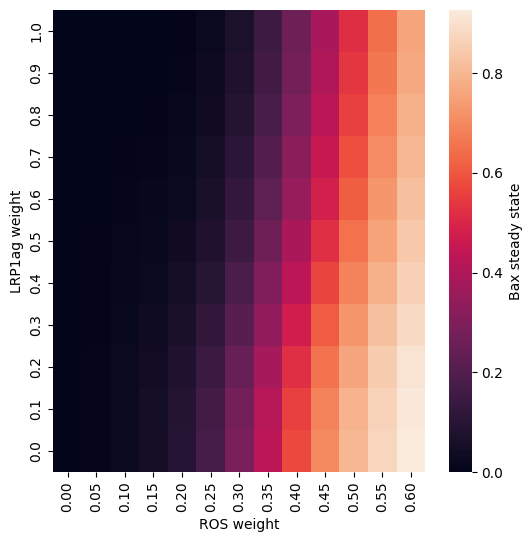

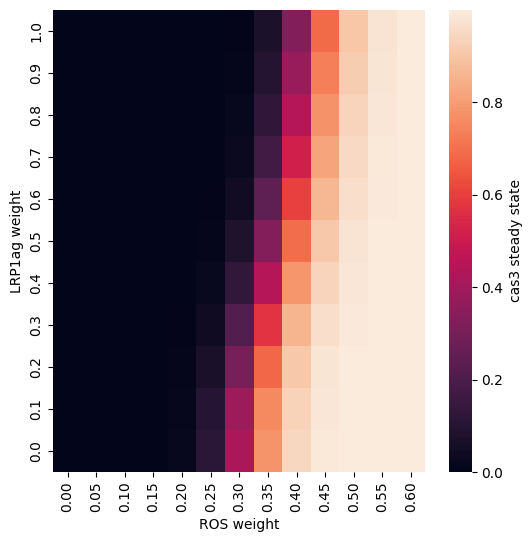

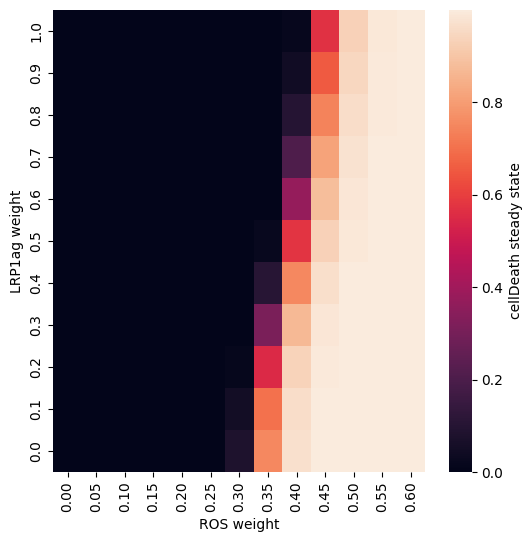

In [85]:
for species, matrix in zip(['Bax', 'cas3', 'cellDeath'], [bax_steady, cas3_steady, celldeath_steady]):
	fig, ax = plt.subplots()
	sns.heatmap(
		matrix[::-1, :], # reverse rows for visualization (see low to high activity)
		cmap = 'rocket',
		cbar_kws = {'label': f'{species} steady state'},
		xticklabels = [f'{w:0.2f}' for w in ws_ros],
		yticklabels = [f'{w:0.1f}' for w in ws_lrp1ag[::-1]],
		ax = ax,
	)
	ax.set(xlabel='ROS weight', ylabel='LRP1ag weight')
	ax.figure.set_size_inches(6, 6)

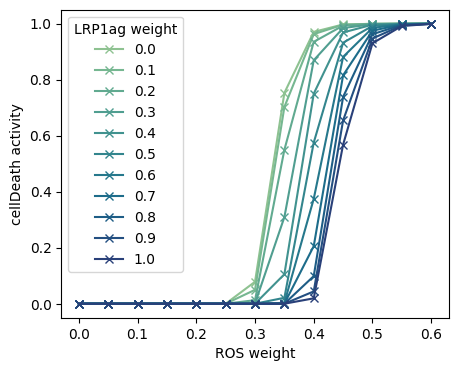

In [86]:
# N = LRP1ag weights
palette = sns.color_palette('crest', n_colors=N)
fig, ax = plt.subplots()

# plot cellDeath steady state levels at different ROS weights
for i, lrp1ag_weight in enumerate(ws_lrp1ag):
	plt.plot(ws_ros, celldeath_steady[i, :], color=palette[i], marker='x', label=f'{lrp1ag_weight:0.1f}')
ax.set(xlabel='ROS weight', ylabel='cellDeath activity')
plt.legend(title='LRP1ag weight')
fig.set_size_inches(5, 4)

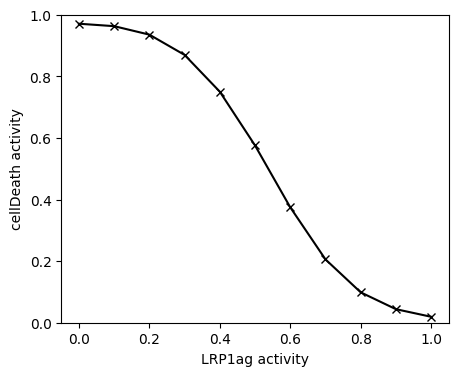

In [87]:
# cellDeath in response to LRP1ag weights during MI
fig, ax = plt.subplots()
# 8 corresponds to ROS at 0.4
plt.plot(ws_lrp1ag, celldeath_steady[:, 8], color='k', marker='x')
ax.set(ylim=(0, 1), xlabel='LRP1ag activity', ylabel='cellDeath activity')
fig.set_size_inches(5, 4)

In [88]:
# Query = filter results based on a true/false condition 
steady_long = results.query('time == @tspan[1]').drop(columns="time")
display(steady_long)

# Save steady state for each example condition
# Group staedy state activity for each species based on ROS/LRP1ag condition
steady_base = steady_long.pivot(index='species', columns='condition', values='activity').loc[speciesNames]

# Add column for values when ROS is overexpressed
steady_base['ros_OE_lrp_0.2'] = steady_base['ros_0.4_lrp_0.2'] - steady_base['ros_0.05_lrp_0.2']

# Add when LRP1ag is overexpressed
steady_base['ros_0.4_lrp_OE'] = steady_base['ros_0.4_lrp_1.0'] - steady_base['ros_0.4_lrp_0.2']

,species,activity,condition
201,AP1,0.000545,ros_0.05_lrp_0.2
403,ASK1,0.029610,ros_0.05_lrp_0.2
100,Akt,0.631601,ros_0.05_lrp_0.2
504,Bad,0.355516,ros_0.05_lrp_0.2
605,Bax,0.008701,ros_0.05_lrp_0.2
...,...,...,...
2625,iCADt,1.000000,ros_0.6_lrp_0.2
4241,p38,0.741797,ros_0.6_lrp_0.2
4342,p53,0.777166,ros_0.6_lrp_0.2
6160,xIAP,0.063215,ros_0.6_lrp_0.2


/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1_ODE.py:142: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)
/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1_ODE.py:142: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


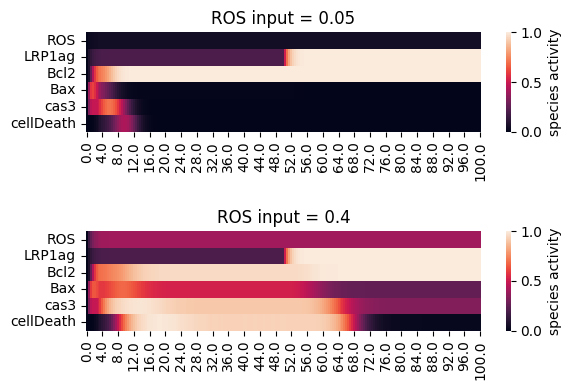

In [89]:
species_of_interest = ['ROS', 'LRP1ag', 'Bcl2', 'Bax', 'cas3', 'cellDeath']

time_course_fig, axs = plt.subplots(2, 1)
# Low and high ROS (MI vs. No MI)
for i, condition in enumerate(('ros_0.05_lrp_0.2', 'ros_0.4_lrp_0.2')):
	w_new = w.copy()
	# Turn on LRP1ag
	w_new[0] = 1.0
	# Turn on ROS at respective weights (0.05, then 0.04)
	w_new[12] = conditions[condition][1]
	# Grab activity levels for all species, based on condition -> this is y0
	y0_new = steady_base.loc[speciesNames, condition]
	# time begins at steady state
	tspan_new = [tspan[1], tspan[1]*2]
	sol = solve_ivp(LRP1_ODE.ODEfunc, tspan_new, y0_new, args=(tau, ymax, w_new, n, EC50,), t_eval=np.linspace(*tspan_new, len(t_eval)))

    
	prev_time_course = (
		# filter results only based on current condition
		# grab species of interest activity only for all time stamps [0 to 50]
		results.query('condition == @condition').
		pivot(index='species', columns='time', values='activity').
		loc[species_of_interest, :]
	)
	
    # ODE from t = 50 to 100, for species of interest only
	new_time_course = pd.DataFrame(sol.y, index=speciesNames, columns=sol.t).loc[species_of_interest]

	ax = sns.heatmap(
		# combine previous and new time together (t = 0 to 100)
		data = prev_time_course.join(new_time_course.drop(columns=50)),
		vmin = 0, vmax = 1,
		cmap = 'rocket',
		cbar_kws = {'label': 'species activity'},
		yticklabels = species_of_interest,
		ax = axs[i],
	)
	ax.set(title=f'ROS input = {w_new[12]}', ylabel=None)
time_course_fig.set_size_inches(6, 4)
time_course_fig.tight_layout(h_pad=2)

In [90]:
# S = len(species)

# create dict to fill in steady state KD values for each condition
steady_kd = {condition: np.zeros((S, S)) for condition in conditions}

# knocking down each species under each LRP1/ROS condition 
for i in range(S):
	# simulate knockdown: ymax becomes 0 for each species one by one
	ymax_kd = ymax.copy()
	ymax_kd[i] = 0
	for condition in steady_kd:
		# y0 = steady state values for current condition
		y_steady = steady_base[condition]
		# grab LRP1ag weight and ros_weight for current condition
		lrp1ag_weight, ros_weight = conditions[condition]
		w_new = w.copy()
		# change LRP1ag and ROS weight to current condition
		w_new[0] = lrp1ag_weight
		w_new[12] = ros_weight
		
		sol_kd = solve_ivp(LRP1_ODE.ODEfunc, tspan, y_steady, args=(tau, ymax_kd, w_new, n, EC50,), t_eval=t_eval)
		
        # steady state values for each species upon knockdown of current specie for each condition
		steady_kd[condition][:, i] = sol_kd.y[:, -1]

/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1_ODE.py:142: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


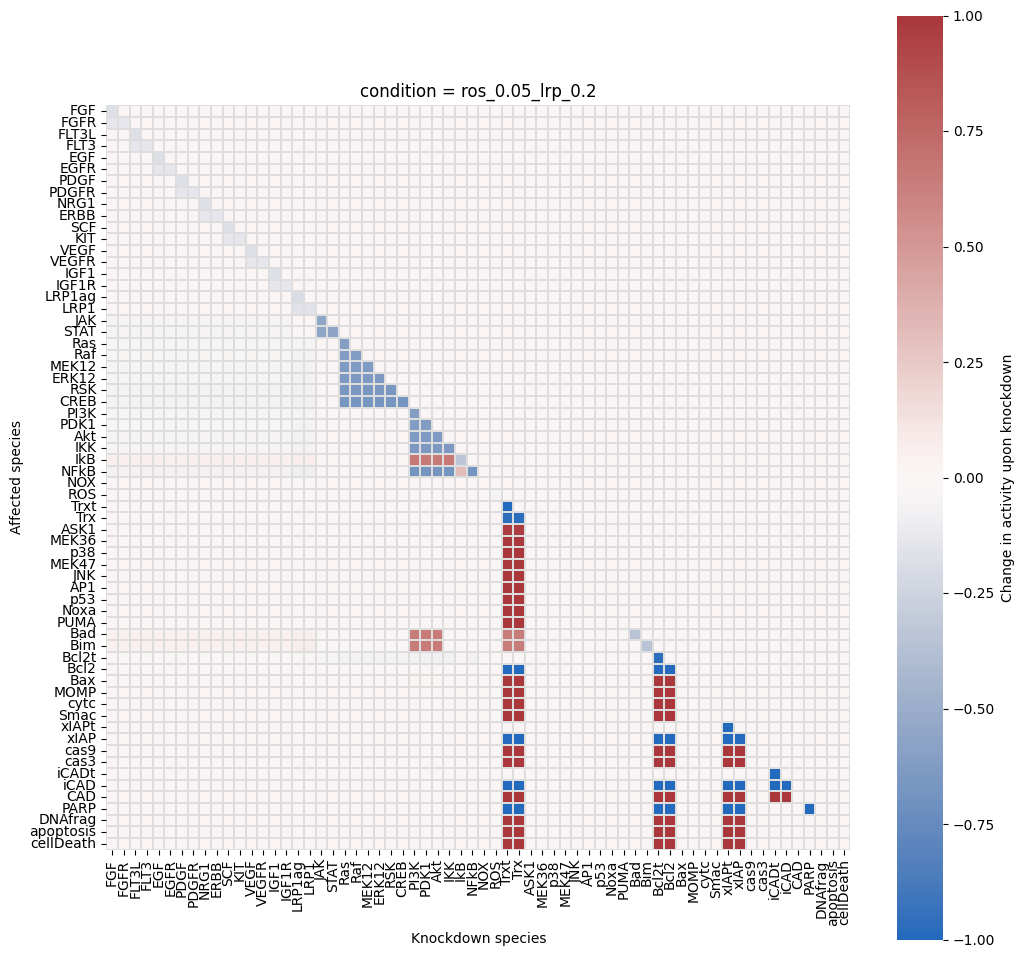

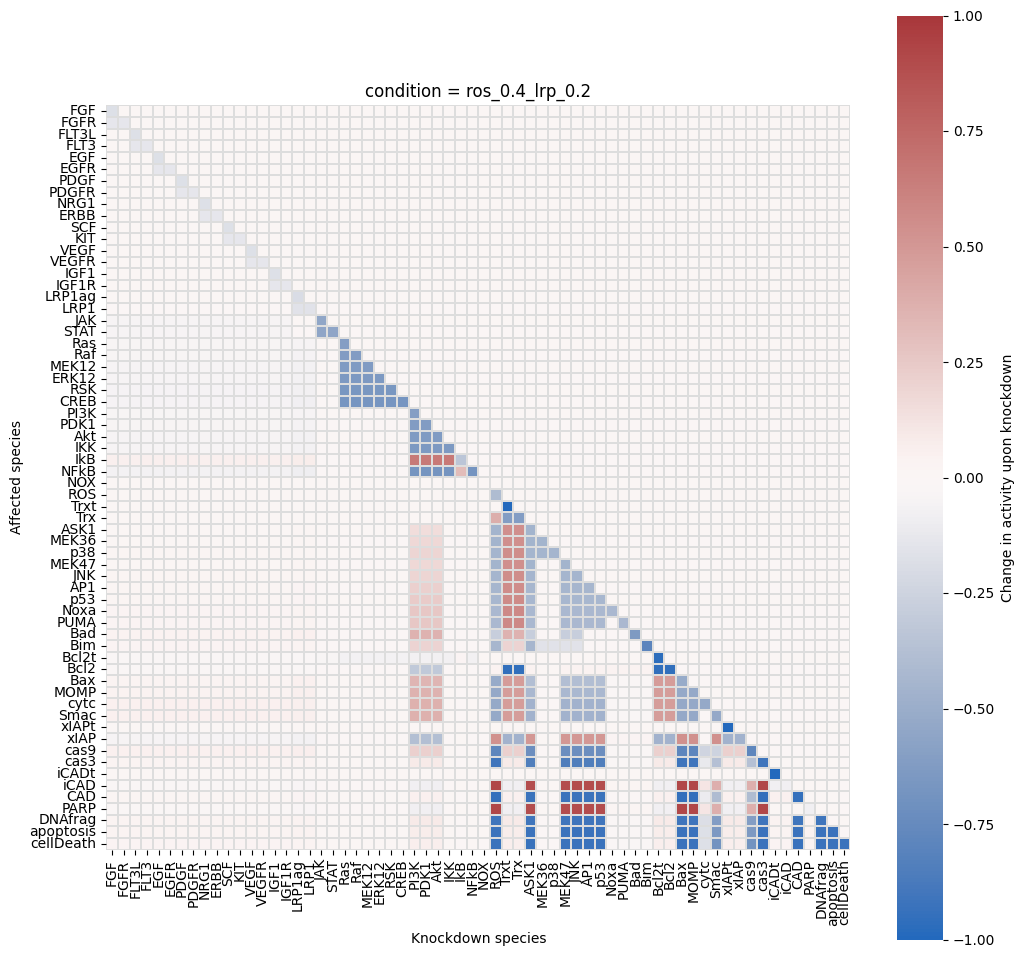

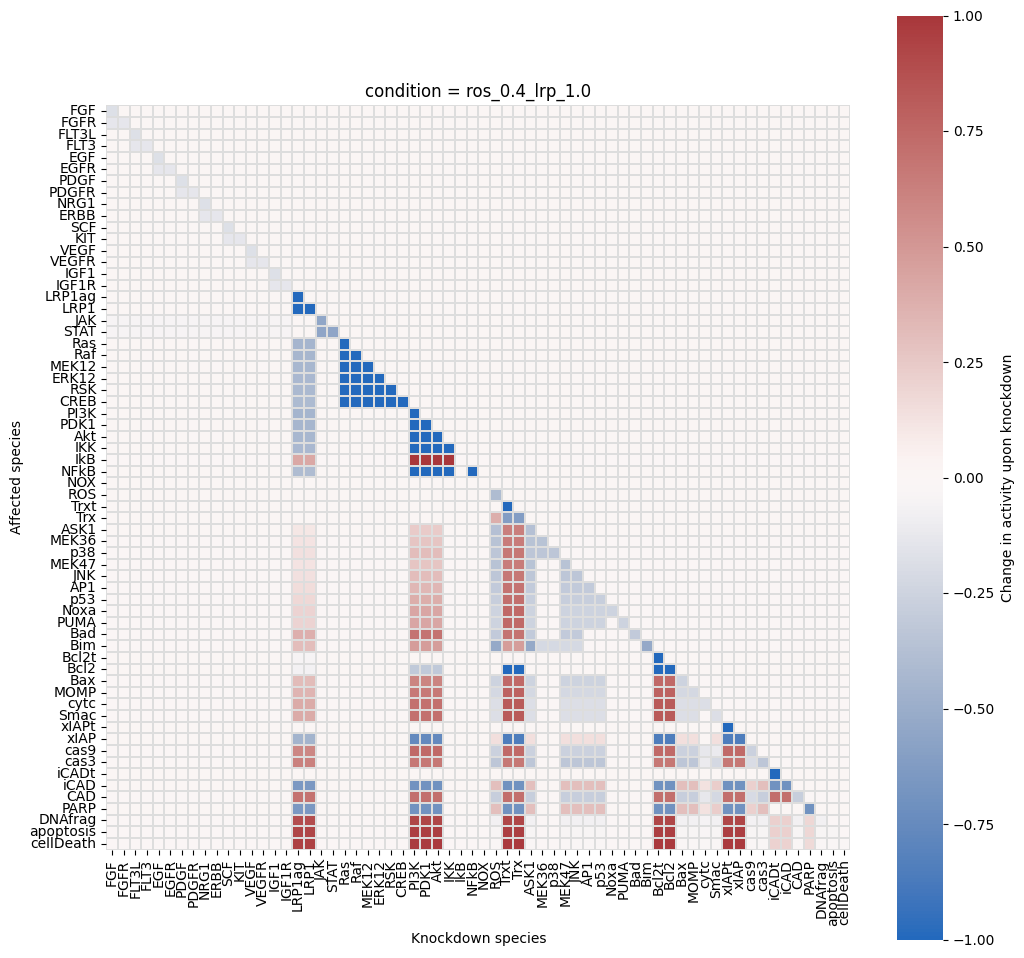

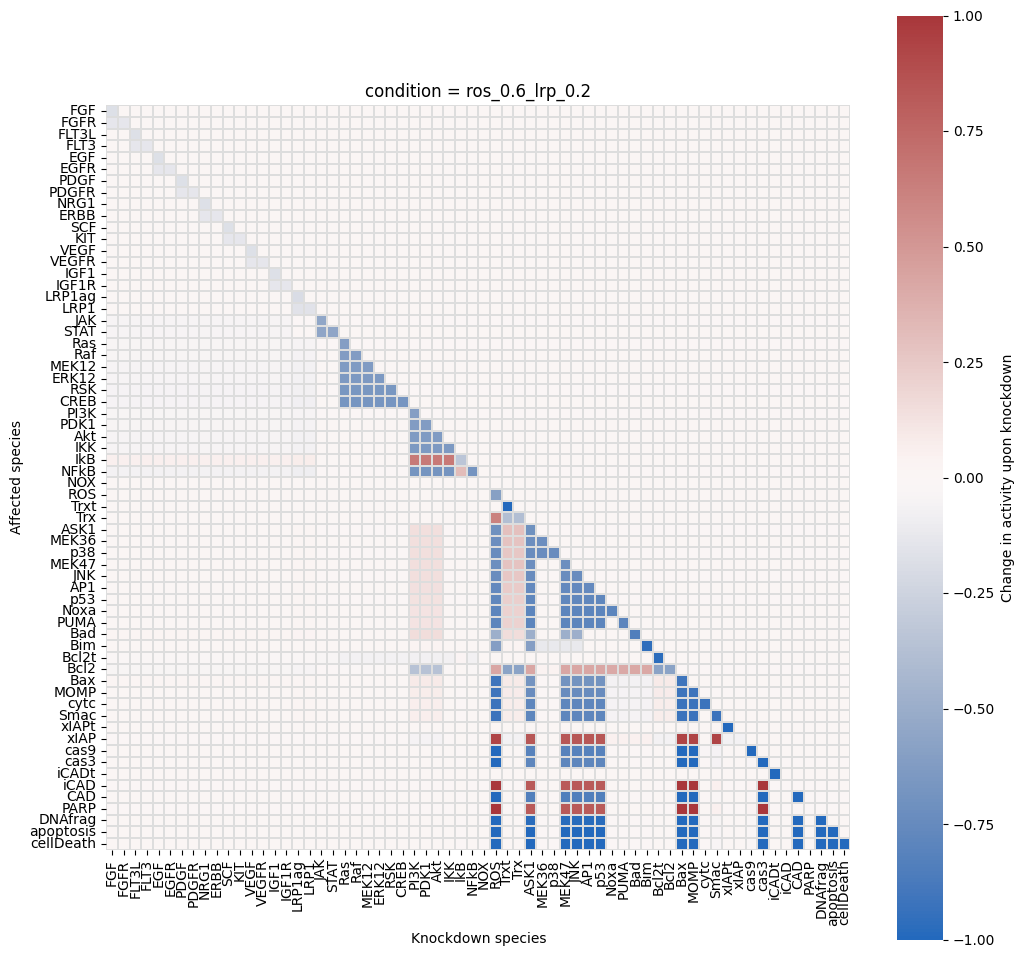

In [91]:
celldeath_sens_raw = {}
for condition in conditions:
	diff = steady_kd[condition] - steady_base[condition].to_numpy()[:, None]
	
    # sensitivity for cell death upon knockdown of each species
	celldeath_sens_raw[condition] = diff[celldeath_index, :]

	fig, ax = plt.subplots()
	sns.heatmap(
		diff[sorted_indices, :][:, sorted_indices],
		vmin = -1, center = 0, vmax = 1,
		cmap = 'vlag',
		cbar_kws = {'label': f'Change in activity upon knockdown'},
		xticklabels = sorted_species,
		yticklabels = sorted_species,
		square = True,
		linewidth = 0.1, linecolor = '#dddddd',
		ax = ax,
	)
	ax.set(
		xlabel = 'Knockdown species',
		ylabel = 'Affected species',
		title = f'condition = {condition}',
	)
	fig.set_size_inches(12, 12)

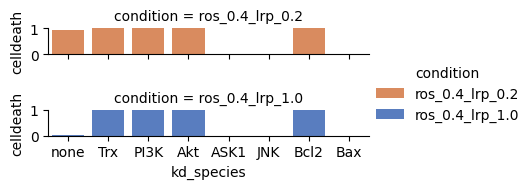

In [92]:
# dataframe for cell death sensitivity levels for all 3 conditions
celldeath_sens = pd.DataFrame(data=celldeath_sens_raw, index=pd.Index(speciesNames, name='kd_species'))

# only interested in LRP1ag differences
celldeath_kd = celldeath_sens[['ros_0.4_lrp_0.2', 'ros_0.4_lrp_1.0']].copy()
celldeath_kd.index.names = ['kd_species']
# adds celldeath_kd index named 'none' for baseline values of cell death under each condition
celldeath_kd.loc['none', :] = 0
# add baseline steady state values for cellDeath to steady state values upon knockdown
# species offset = 0 
celldeath_kd = celldeath_kd + steady_base.loc['cellDeath', celldeath_kd.columns]
celldeath_kd_long = (
	celldeath_kd.
	reset_index(drop=False).
	melt(id_vars='kd_species', var_name='condition', value_name='celldeath')
)

lrp_palette = sns.color_palette('muted', 2)[::-1]
fig = sns.catplot(
	data = celldeath_kd_long,
	x = 'kd_species',
	order = (
		'none', 'Trx', 'PI3K', 'Akt', 'ASK1', 'JNK', 'Bcl2', 'Bax',
	),
	y = 'celldeath',
	kind = 'bar',
	hue = 'condition', palette = lrp_palette,
	dodge = False,
	row = 'condition',
	height = 1, aspect = 4,
	facet_kws = {
		'ylim': (0, 1),
		# 'xlabel': 'Knockdown species',
		# 'ylabel': 'Cell death',
	}
)

<ipython-input-93-c05d80ec1441>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-93-c05d80ec1441>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(
<ipython-input-93-c05d80ec1441>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-93-c05d80ec1441>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(
<ipython-input-93-c05d80ec1441>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `lege

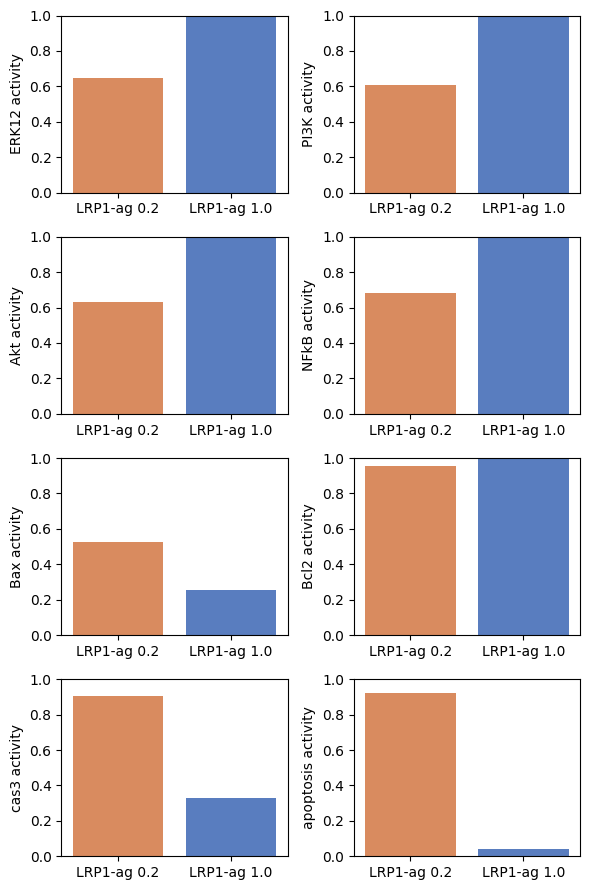

In [93]:
fig, axs = plt.subplots(4, 2)
validation_species = ('ERK12', 'PI3K', 'Akt', 'NFkB', 'Bax', 'Bcl2', 'cas3', 'apoptosis')


# plotting steady state values for each validation species at both conditions
for species, ax in zip(validation_species, axs.flatten()):
	sns.barplot(
		data = steady_long[steady_long['species'] == species].reset_index(drop=True),
		x = 'condition',
		y = 'activity',
		order = ['ros_0.4_lrp_0.2', 'ros_0.4_lrp_1.0'],
		palette = lrp_palette,
		ax = ax,
	)
	
	ax.set(
		xticklabels = ('LRP1-ag 0.2', 'LRP1-ag 1.0'),
		xlabel = '',
		ylim = (0, 1),
		ylabel = f'{species} activity',
	)
fig.set_size_inches(6, 9)
fig.tight_layout()